In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import warnings

from matplotlib.cm import ScalarMappable

# Filter away useless warnings
warnings.filterwarnings("ignore")

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Loading dataset

In [2]:
penguins = pd.read_csv('https://datasets.holoviz.org/penguins/v1/penguins.csv')
penguins = penguins[~penguins.sex.isnull()].reset_index().sort_values('species')

penguins.nunique()

index                333
species                3
island                 3
bill_length_mm       163
bill_depth_mm         79
flipper_length_mm     54
body_mass_g           93
sex                    2
year                   3
dtype: int64

# Vague scatter plot

In [3]:
# Theme colors
DARKBLUE = "#1d1330"
ORANGE = "#ffa72b"
LIGHTBLUE = "#e1f7fa"

# Function to get species data
def get_values(species):
    cond = penguins["species"] == species
    
    flipper = penguins[cond].flipper_length_mm.values
    body = penguins[cond].body_mass_g.values
    sex = penguins[cond].sex.values
    count = penguins[cond].index.values
    year = penguins[cond].year.values
    
    # Scaling function to adjust median gain between min and max value
    def scale(x, lower=0, upper=1):
        return ((x - np.min(x)) / (np.max(x) - np.min(x))) * (upper - lower)  + lower

    alpha = scale(year, 0.2, 0.75)
    sizes = scale(flipper, 5, 200)

    # Array with the colors for sex
    colors = np.where(sex == "male", LIGHTBLUE, ORANGE)
    
    return count, body, colors, sizes, alpha

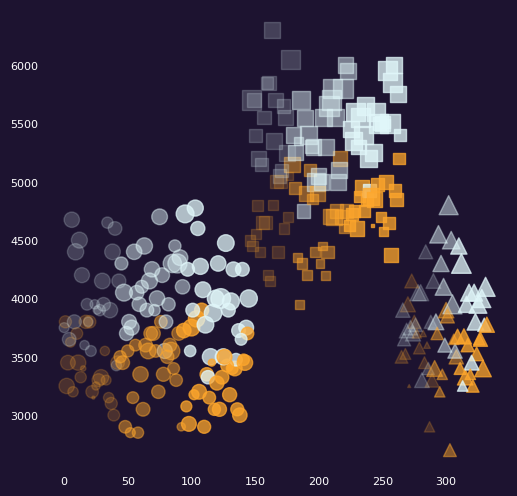

In [4]:
fig, ax = plt.subplots(figsize=(6, 6))

fig.set_facecolor(DARKBLUE)
ax.set_facecolor(DARKBLUE)

# Remove frame (or all the spines at the same time)
ax.set_frame_on(False)

# Color and size - tick labels
ax.tick_params(axis="both", colors="white", labelsize=8)

# Remove tick marks from both axes
ax.tick_params(length=0)

species_marker = {"Adelie": "o", "Gentoo": "s", "Chinstrap": "^"}

# Iterate through "species_marker" and plot species data with their assigned marker
for species, marker in species_marker.items():
    count, body, colors, sizes, alpha = get_values(species)
    ax.scatter(count, body, color=colors, sizes=sizes, alpha=alpha, marker=marker)

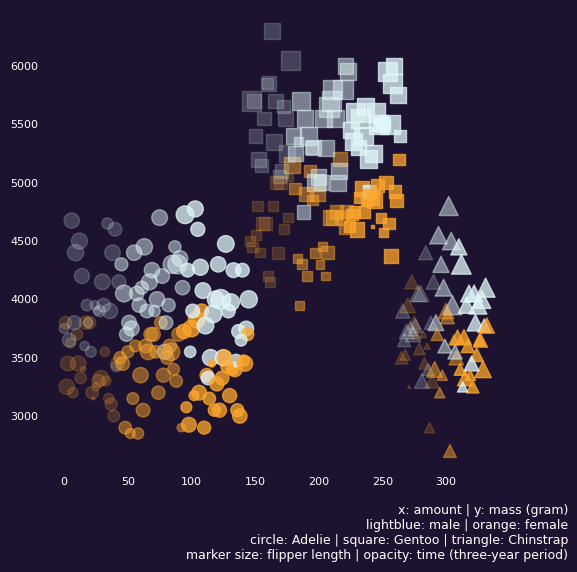

In [5]:
# Add text for legend
legend_text = "\n".join([
    "x: amount | y: mass (gram)",
    "lightblue: male | orange: female",
    "circle: Adelie | square: Gentoo | triangle: Chinstrap",
    "marker size: flipper length | opacity: time (three-year period)"
])

fig.text(1, -0.04, legend_text, ha="right", va="bottom", size=9, color="white")

fig

# Dataframe for ridgeline

In [6]:
# Filtering and formatting columns we need
penguins_df = penguins[["flipper_length_mm", "species", "sex"]]
penguins_df["species"] = penguins.agg(lambda x: f"{x['species']} {x['sex']}", axis=1)
penguins_df = penguins_df.drop(["sex"], axis="columns")
penguins_df.head(5)

,flipper_length_mm,species
0,181.0,Adelie male
94,192.0,Adelie female
95,203.0,Adelie male
96,183.0,Adelie female
97,190.0,Adelie male


In [7]:
# Dictionary for Y labels
label_dict = {1: "Adelie - Male",
              2: "Adelie - Female",
              3: "Chinstrap - Male",
              4: "Chinstrap - Female",
              5: "Gentoo - Male",
              6: "Gentoo - Female"}

Text(0.5, 0.98, 'Central Tendency Of Flipper Length')

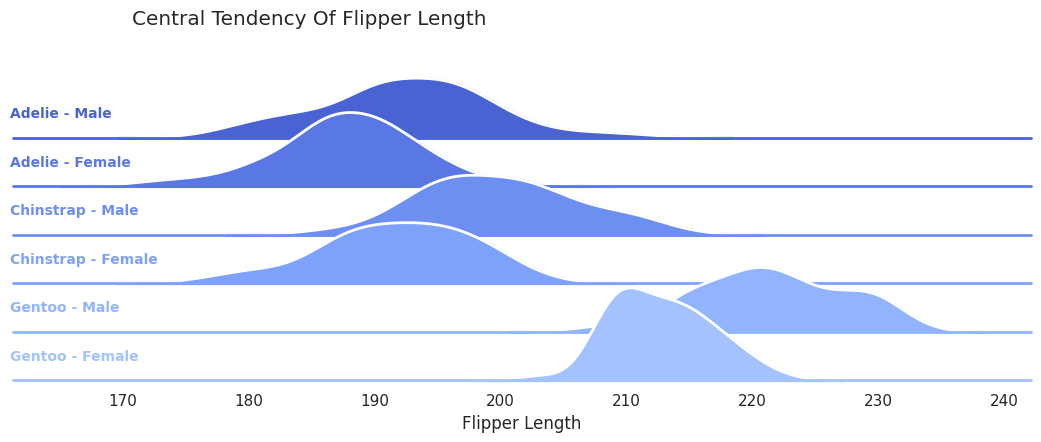

In [8]:
# Setting the color theme
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0), "axes.linewidth":2})

# Generate a color palette with Seaborn.color_palette()
pal = sns.color_palette("coolwarm", n_colors=18)

# sns.FacetGrid class - create a plot for each value in 'species' column
# Making the charts broader and shorter 
# The 'hue' argument is the one that will be represented by colors with 'palette'
ridge = sns.FacetGrid(penguins_df, row="species", hue="species", aspect=15, height=.75, palette=pal)

# map_dataframe - to color fill all the subplots
ridge.map_dataframe(sns.kdeplot, x="flipper_length_mm", bw_adjust=1, clip_on=False, fill=True, alpha=1, linewidth=2)

# Add a white line that represents the contour of each kdeplot    
ridge.map_dataframe(sns.kdeplot, x="flipper_length_mm", bw_adjust=1, clip_on=False, color="white", linewidth=2)

# Add a horizontal line for each plot
ridge.map_dataframe(plt.axhline, y=0, linewidth=2, clip_on=False)

# Loop over the FacetGrid figure axes (g.axes.flat) and add the "values" from label_dict as text with the right color
# ax.lines[-1].get_color() enables access the last line's color in each axes
for i, ax in enumerate(ridge.axes.flat):
    ax.text(161, 0.02, label_dict[i+1],
            fontweight='bold', fontsize=10,
            color=ax.lines[-1].get_color())

# Remove clutter
ridge.set_titles("")
ridge.set(yticks=[], ylabel="", xlabel="Flipper Length")
ridge.despine(bottom=True, left=True)

# subplots_adjust to control the height space between the subplots.
ridge.fig.subplots_adjust(hspace=-.5)
plt.suptitle("Central Tendency Of Flipper Length", ha="right")

# Dataframe for circular barplot

In [9]:
bill_df = penguins.groupby(["island", "species", "sex"], as_index=False).agg({"bill_length_mm": "mean", "bill_depth_mm": "mean"}, ascending=False)

# Concatenate string values from 'species' column and first letter of string values from 'sex' column
bill_df["species"] = bill_df.agg(lambda x: f"{x['species']} ({x['sex'][0]})", axis=1)
final_bill_df = bill_df.drop("sex", axis="columns")
final_bill_df

,island,species,bill_length_mm,bill_depth_mm
0,Biscoe,Adelie (f),37.359091,17.704545
1,Biscoe,Adelie (m),40.590909,19.036364
2,Biscoe,Gentoo (f),45.563793,14.237931
3,Biscoe,Gentoo (m),49.473770,15.718033
4,Dream,Adelie (f),36.911111,17.618519
5,Dream,Adelie (m),40.071429,18.839286
6,Dream,Chinstrap (f),46.573529,17.588235
7,Dream,Chinstrap (m),51.094118,19.252941
8,Torgersen,Adelie (f),37.554167,17.550000
9,Torgersen,Adelie (m),40.586957,19.391304


In [10]:
# Average length and depth
LENGTHS = final_bill_df["bill_length_mm"]
DEPTHS = final_bill_df["bill_depth_mm"]

# Angles for bar orientation
# Add a number of empty bars (PAD) to the end of each group
PAD = 1
GROUP = final_bill_df["island"].values
ANGLES_N = len(LENGTHS) + PAD * len(np.unique(GROUP))
ANGLES = np.linspace(0, 2 * np.pi, num=ANGLES_N, endpoint=False)
WIDTH = (2 * np.pi) / len(ANGLES)

# Species and Sex label
CATEGORIES = final_bill_df["species"]

# Obtain size of each group to create color groups
GROUPS_SIZE = [len(i[1]) for i in final_bill_df.groupby("island")]
COLORS = [f"C{i}" for i, size in enumerate(GROUPS_SIZE) for _ in range(size)]

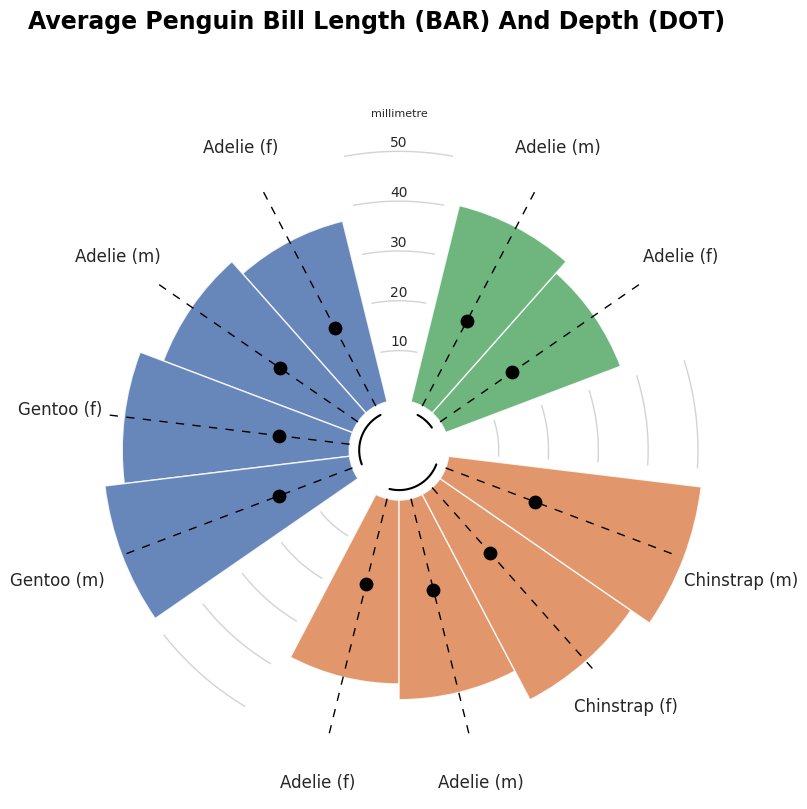

In [11]:
# Obtaining the right indexes
offset = 0
IDXS = []

for size in GROUPS_SIZE:
    IDXS += list(range(offset + PAD, offset + size + PAD))
    offset += size + PAD
# Initialize layout in polar coordinates
fig, ax = plt.subplots(figsize=(9, 12.6), subplot_kw={"projection": "polar"})

# Set background color to white, both axis and figure.
fig.patch.set_facecolor("white")
ax.set_facecolor("white")

ax.set_theta_offset(1.2 * np.pi / 2.4)
ax.set_ylim(-10, 60)

# Add geometries to the plot - zorder to manipulate which geometries are on top
# Add bars to represent average bill length
ax.bar(ANGLES[IDXS], LENGTHS, color=COLORS, alpha=0.85, width=WIDTH, zorder=10)

# Add dotted lines. These are just references
ax.vlines(ANGLES[IDXS], 0, 50, color="black", ls=(0, (6, 6)), linewidth=1, zorder=11)

# Add dots to represent the bill depth
ax.scatter(ANGLES[IDXS], DEPTHS, s=80, color="black", zorder=11)

# Remove lines for polar axis (x)
ax.xaxis.grid(False)
# Lines for axis y
ax.yaxis.grid(False)

# Add labels for bars
CATEGORIES = [r for r in CATEGORIES]
CATEGORIES

# Set the labels
ax.set_xticks(ANGLES[IDXS])
ax.set_xticklabels(CATEGORIES, size=12)

# Put grid lines for radial axis (y) at 0, 10, 20, 30, 40, 50
ax.set_yticklabels([])
ax.set_yticks([0, 10, 20, 30, 40, 50])

# Remove spines
ax.spines["start"].set_color("none")
ax.spines["polar"].set_color("none")

# Adjust padding of the x axis labels
XTICKS = ax.xaxis.get_major_ticks()
i = 0

for tick in XTICKS:
    if i == 7:
        tick.set_pad(-1)
    elif i == 3:
        tick.set_pad(-1)
    else:
        tick.set_pad(-18)
    i += 1

# y ticks value label and legend
PAD = 1

for mm in range(10, 60, 10):
    ax.text(0 * np.pi / 2, mm + PAD, mm, ha="center", size=10)

# y legend
ax.text(0 * np.pi / 2, 56 + PAD, "millimetre", ha="center", size=8)

title = "Average Penguin Bill Length (BAR) And Depth (DOT)"
fig.text(0.1, 0.83, title, fontsize=17, color="black", weight="bold", ha="left", va="baseline")

# This iterates over the sizes of the groups adding reference lines
offset = 0

for size in GROUPS_SIZE:
    # Add line below bars
    x1 = np.linspace(ANGLES[offset + PAD], ANGLES[offset + size + PAD - 1], num=20)
    ax.plot(x1, [-2] * 20, color="black")
    
    # Add reference lines at 10, 20, 30, 40 and 50 - adjust (ANGLES[offset] - *) for line length
    x2 = np.linspace(ANGLES[offset] - 0.18, ANGLES[offset + PAD] - 0.3, num=20)
    
    for mm in range(10, 60, 10):
        ax.plot(x2, [mm] * 20, color="lightgrey", lw=1)
        
    offset += size + PAD

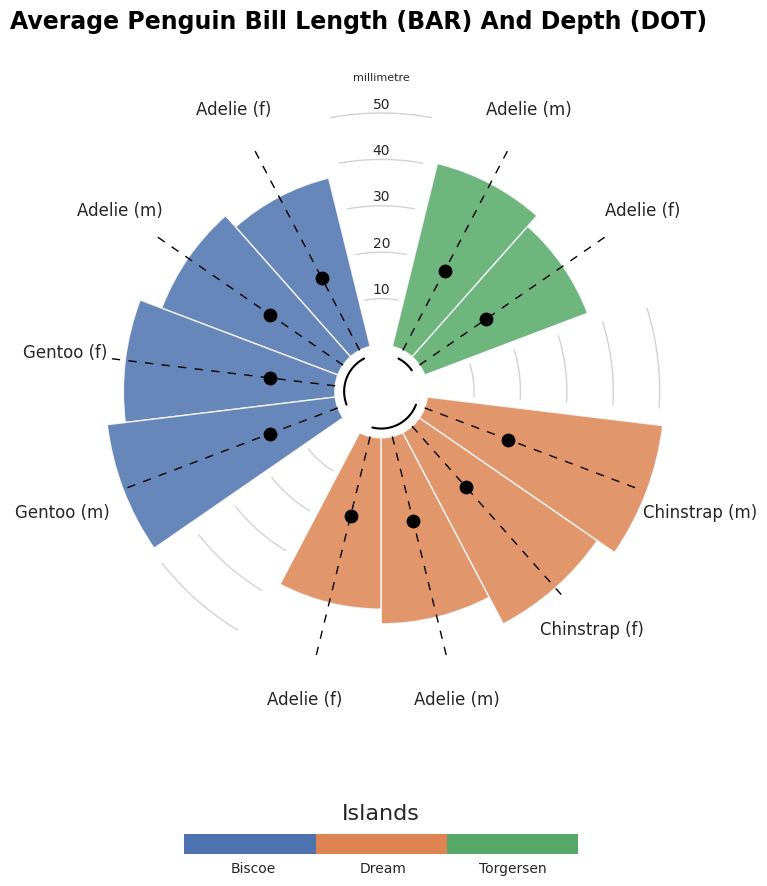

In [12]:
# Colormap
cmap = mpl.colors.LinearSegmentedColormap.from_list("color", COLORS, N=256)

# First, make some room for the legend and the caption in the bottom.
fig.subplots_adjust(top=0.8)
fig.subplots_adjust(bottom=0.175)

# Create a new norm, which is discrete
bounds = [0, 1, 2, 3]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

# Create the colorbar legend
cb = fig.colorbar(
    ScalarMappable(norm=norm, cmap=cmap),
    orientation = "horizontal", 
    fraction=0.025
)

# Remove the outline of the colorbar
cb.outline.set_visible(False)

# Remove tick marks
cb.ax.xaxis.set_tick_params(size=0)

# Set legend label and move it to the top (instead of default bottom)
cb.set_label("Islands", size=16, labelpad=-40)
cb.set_ticks(ticks=bounds, labels=["", '', '', ''])

fig.text(0.370, 0.16, "Biscoe", fontsize=10, ha="center", va="baseline")
fig.text(0.515, 0.16, "Dream", fontsize=10, ha="center", va="baseline")
fig.text(0.659, 0.16, "Torgersen", fontsize=10, ha="center", va="baseline")

fig